# Label Exploration

## Count the number of subjects with labels

In [1]:
import csv
from os import listdir
from os.path import exists

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# label_file_path = r"/imaging3/owenlab/bpho/Biobank Labels/BehavData.csv"
label_file_path = r"/imaging3/owenlab/bpho/Biobank Labels/data-2020-07-21T15_31_07.904Z.csv"

In [3]:
label_subject_ids = set()

with open(label_file_path) as csvfile:
    reader = csv.DictReader(csvfile)
    label_subject_ids = label_subject_ids.union(
        {row['assessment WISC,EID'] for row in reader})

# print(label_subject_ids)
print("Number of labels:", len(label_subject_ids))

Number of labels: 2279


In [4]:
data_subject_ids = set()

for age in range(5, 19):
    age_dir = f'/imaging3/owenlab/bpho/python_power_fc/Age{age}'
    
    if not exists(age_dir):
        continue
    
    data_subject_ids = data_subject_ids.union(
        {folder[4:] for folder in listdir(age_dir) if folder.startswith("sub-")})

    
print("Number of subjects:", len(data_subject_ids))

Number of subjects: 722


In [5]:
subjects_with_labels = label_subject_ids.intersection(data_subject_ids)
# print(subjects_with_labels)
print("Number of subjects with labels:", len(subjects_with_labels))

Number of subjects with labels: 438


## Pandas Section (Write Labels to CSV)

In [16]:
subjects = pd.DataFrame(data_subject_ids, columns=['assessment WISC,EID'], dtype='str')
labels = pd.read_csv(label_file_path, dtype='str')
ages = labels["assessment Basic_Demos,Age"]
labels = labels.filter(like="WISC").join(ages)

display(subjects)
display(labels)

,"assessment WISC,EID"
0,NDARXD907ZJL
1,NDARFX508WPN
2,NDARER379GTP
3,NDARKD590VF4
4,NDARNT225UVD
...,...
717,NDARLB671TLU
718,NDARPJ001BVE
719,NDARHM611GDR
720,NDARUC715YN4


,"assessment WISC,Administration","assessment WISC,Comment_ID","assessment WISC,Data_entry","assessment WISC,Days_Baseline","assessment WISC,EID","assessment WISC,PSCID","assessment WISC,START_DATE","assessment WISC,Season","assessment WISC,Site","assessment WISC,Study",...,"assessment WISC,WISC_VSI_Sum","assessment WISC,WISC_Vocab_Raw","assessment WISC,WISC_Vocab_Scaled","assessment WISC,WISC_WMI","assessment WISC,WISC_WMI_Percentile","assessment WISC,WISC_WMI_Sum","assessment WISC,WISC_complete","assessment WISC,WISC_incomplete_reason","assessment WISC,Year","assessment Basic_Demos,Age"
0,All,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.
1,All,NaN,Complete,15,NDARAA075AMK,NaN,1901-01-01T07:00:00Z,Summer,2,HBN,...,28,32,18,155,99.9,38,1,NaN,2016,6.72804
2,.,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,5.545744
3,All,NaN,Complete,70,NDARAA117NEJ,NaN,1901-01-01T07:00:00Z,Winter,1,HBN,...,14,18,11,85,16,15,1,NaN,2017,7.475929
4,All,NaN,Complete,5,NDARAA504CRN,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,...,21,21,9,97,42,19,1,NaN,2019,9.165297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,.,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4187,.,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4188,.,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.
4189,.,.,.,.,.,.,.,.,.,.,...,.,.,.,.,.,.,.,.,.,.


In [17]:
subjects_with_labels = labels.merge(subjects, on='assessment WISC,EID')
subjects_with_labels.set_index(keys='assessment WISC,EID', inplace=True)
display(subjects_with_labels)

,"assessment WISC,Administration","assessment WISC,Comment_ID","assessment WISC,Data_entry","assessment WISC,Days_Baseline","assessment WISC,PSCID","assessment WISC,START_DATE","assessment WISC,Season","assessment WISC,Site","assessment WISC,Study","assessment WISC,Visit_label",...,"assessment WISC,WISC_VSI_Sum","assessment WISC,WISC_Vocab_Raw","assessment WISC,WISC_Vocab_Scaled","assessment WISC,WISC_WMI","assessment WISC,WISC_WMI_Percentile","assessment WISC,WISC_WMI_Sum","assessment WISC,WISC_complete","assessment WISC,WISC_incomplete_reason","assessment WISC,Year","assessment Basic_Demos,Age"
"assessment WISC,EID",,,,,,,,,,,,,,,,,,,,,
NDARAC331VEH,All,NaN,Complete,2,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,30,40,13,110,75,23,1,NaN,2019,14.167351
NDARAC462DZH,All,NaN,Complete,74,NaN,1901-01-01T07:00:00Z,Spring,1,HBN,NaN,...,9,18,10,76,5,12,1,NaN,2019,7.957449
NDARAF440XWG,All,NaN,Complete,104,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,27,15,9,110,75,23,1,NaN,2019,7.253593
NDARAF535XK6,All,NaN,Complete,77,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,13,18,4,97,42,19,1,NaN,2019,13.121492
NDARAG115LZP,All,NaN,Complete,135,NaN,1901-01-01T07:00:00Z,Spring,3,HBN,NaN,...,29,32,9,91,27,17,1,NaN,2018,14.167351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARRL426AD5,All,NaN,Complete,119,NaN,1901-01-01T07:00:00Z,Fall,1,HBN,NaN,...,13,25,9,91,27,17,1,NaN,2018,11.234998
NDARTT272WT5,All,NaN,Complete,385,NaN,1901-01-01T07:00:00Z,Summer,1,HBN,NaN,...,21,34,11,100,50,20,1,NaN,2019,12.537759
NDARVB842ZM8,All,NaN,Complete,307,NaN,1901-01-01T07:00:00Z,Summer,1,HBN,NaN,...,12,26,9,117,87,26,1,NaN,2019,11.243326


In [18]:
subjects_with_labels = subjects_with_labels.loc[
    subjects_with_labels['assessment WISC,WISC_complete'] == '1']
print("Number of subjects with WISC labels:", len(subjects_with_labels))

Number of subjects with WISC labels: 425


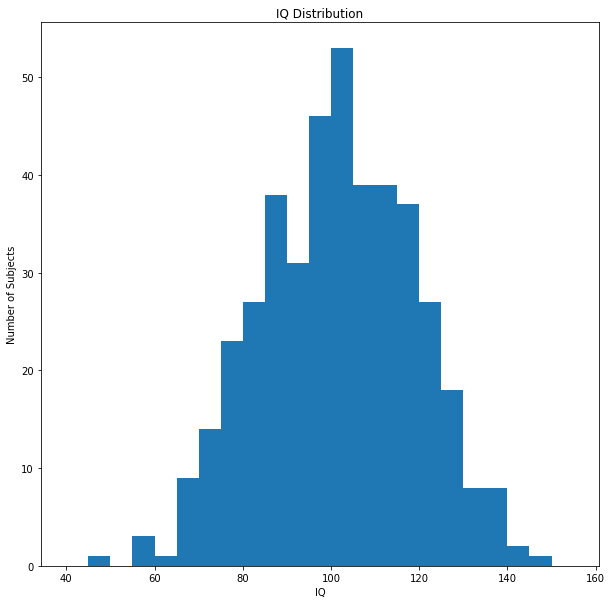

In [25]:
plt.figure(1, figsize=(10, 10))
plt.hist(
    x=subjects_with_labels['assessment WISC,WISC_FSIQ'].astype(int), 
    bins=range(40, 160, 5))
plt.title("IQ Distribution")
plt.xlabel('IQ')
plt.ylabel('Number of Subjects')
plt.show()

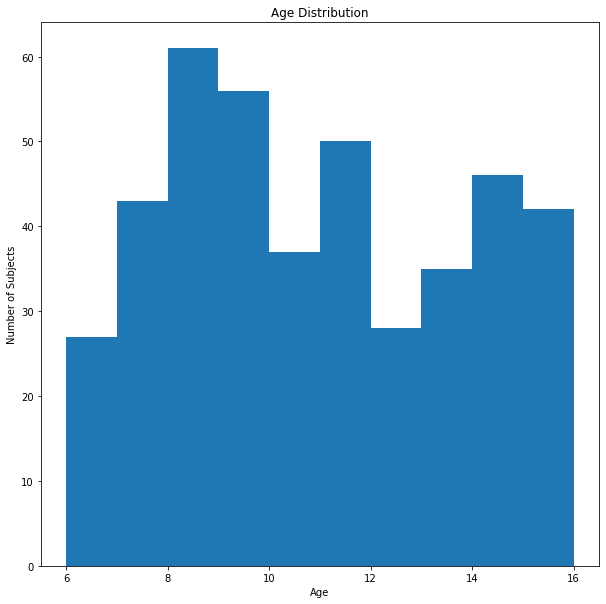

In [28]:
plt.figure(1, figsize=(10, 10))
plt.hist(
    x=subjects_with_labels['assessment Basic_Demos,Age'].astype(float),
    bins=range(6, 17, 1)
)
plt.title("Age Distribution")
plt.xlabel('Age')
plt.ylabel('Number of Subjects')
plt.show()

In [22]:
csv_output_path = "/imaging3/owenlab/bpho/Biobank Labels/Subjects with WISC.csv"
subjects_with_labels.to_csv(csv_output_path)